In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('TSLA', start='2016-01-01', end='2022-08-07')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500
2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000
2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500
2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500
2016-01-08,43.571999,44.088001,42.153999,42.200001,42.200001,18140500


In [ ]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1.660000e+03
mean,273.717841,280.018738,266.925605,273.666822,273.666822,3.994732e+07
std,330.059494,337.859714,321.382788,329.747939,329.747939,2.812848e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,8.297500e+06
25%,51.468001,52.391500,50.442500,51.429999,51.429999,2.282962e+07
50%,68.083000,69.396999,66.947998,68.198002,68.198002,3.118455e+07
75%,585.062485,598.987473,570.612518,585.010010,585.010010,4.589650e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [ ]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-01,903.830017,935.630005,885.000000,891.830017,891.830017,39014300
2022-08-02,882.010010,923.500000,878.000000,901.760010,901.760010,31859200
2022-08-03,915.000000,928.650024,903.450012,922.190002,922.190002,26697000
2022-08-04,933.000000,940.820007,915.000000,925.900024,925.900024,24085400
2022-08-05,908.010010,913.820007,856.630005,864.510010,864.510010,37655300


Text(0, 0.5, 'Prices ($)')

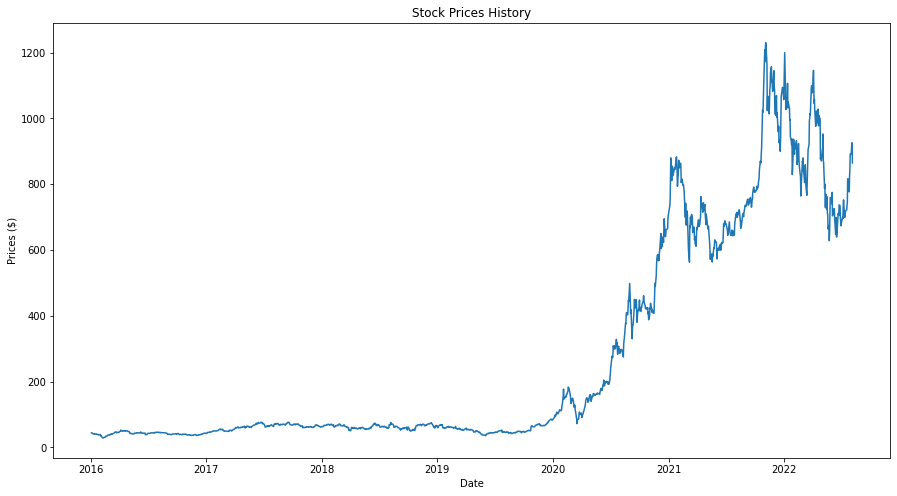

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1268/1268 [==============================] - 51s 36ms/step - loss: 0.0013
Epoch 2/3
1268/1268 [==============================] - 45s 35ms/step - loss: 6.3942e-04
Epoch 3/3
1268/1268 [==============================] - 45s 35ms/step - loss: 5.2230e-04


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

41.60068410850433

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


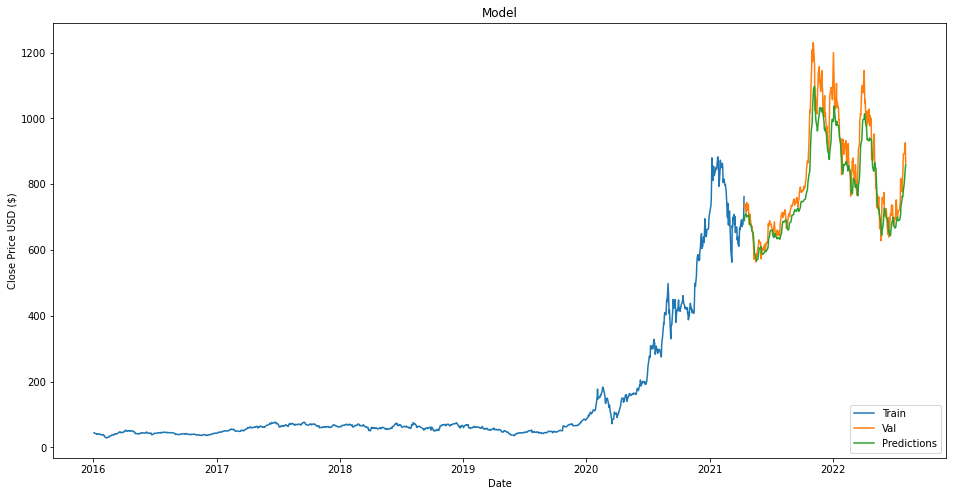

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()